In [1]:
from pygraphblas import *
from itertools import repeat
from time import time
import random
from numba import njit
from pygraphblas.demo.gviz import draw

options_set(nthreads=1)

In [2]:
from collections import defaultdict
from itertools import groupby
from operator import itemgetter

def group_labels(T):
    d = defaultdict(list)
    for k,v in groupby(T, itemgetter(1)):
        d[k].append(list(v)[0][0])
    return d

def compare_groups(left, right):
    left = {k: set(v) for k, v in left.items()}
    right = {k: set(v) for k, v in right.items()}
    return sorted(left.values()) == sorted(right.values())

def get_louvain_cluster_assignments(cluster_matrix):
    clusters = Vector.sparse(UINT64, cluster_matrix.nrows)
    index_of_vec = Vector.sparse(UINT64, cluster_matrix.ncols)
    for i in range(cluster_matrix.nrows):
        index_of_vec[i] = i
    cluster_matrix.mxv(index_of_vec, out=clusters, semiring=UINT64.MAX_SECOND)
    return clusters

In [3]:
M = Matrix.from_lists(
    [0, 0, 0, 0,
    1, 1, 1, 1,
    2, 2, 2, 2,
    3, 3, 3, 3,
    4, 4, 4, 4,
    5, 5, 5, 5, 5,
    6, 6, 6,
    7, 7, 7, 7],
    [0, 2, 3, 6,
    1, 2, 3, 7,
    0, 2, 4, 6,
    0, 1, 3, 5,
    0, 2, 4, 6,
    1, 3, 5, 6, 7,
    0, 4, 6,
    1, 3, 5, 7],
    list(repeat(1.0, 32)),
    typ=FP64,
)

@njit
def seed_rng(seed):
    random.seed(seed)

@unary_op(FP64)  
def random_scaler(x): 
    return random.uniform(0.0001, x)

In [6]:
def louvain_cluster(graph, max_iters=20, seed=None):
    if seed:
        seed_rng(seed)
    assert graph.square, 'First input matrix must be square.'
    start = time()
    rows = graph.nrows
    ApAT = graph.dup()
    graph.transpose(out=ApAT, accum=FP64.PLUS)
    k = graph.reduce_vector()
    m = k.reduce_int() / 2.0    
    S = Matrix.identity(BOOL, rows, format=lib.GxB_BY_COL)
    S_row = Vector.sparse(BOOL, rows)
    empty = Vector.sparse(BOOL, rows)   
    v = Vector.sparse(FP64, rows)
    vertices_changed = True
    iters = 0
    
    while vertices_changed and iters < max_iters:
        vertices_changed = False
        for i in range(rows):
            if i in k:
                S.extract_col(i, out=S_row)
                S.assign_row(i, empty)
                ApAT.extract_row(i, out=v)
                w = k.dup()
                w.assign_scalar(-k[i]/m, accum=FP64.TIMES, mask=k)
                v += w
                q = v @ S
                kappa = q.reduce_float(FP64.MAX_MONOID)
                t = q.select('==', kappa)
                while len(t) != 1:
                    p = t.apply(random_scaler)
                    max_p = p.reduce_float(FP64.MAX_MONOID)
                    t = p.select('==', max_p)
                S.assign_row(i, t)
                if not t.iseq(S_row):
                    vertices_changed = True
        iters += 1
    print('Input size ', len(graph), ' took ', time() - start)
    return S

Input size  32  took  0.06824922561645508


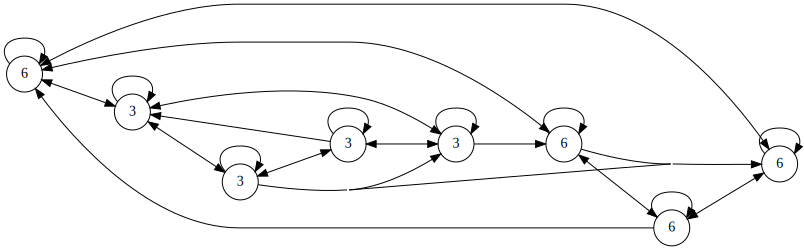

In [7]:
ans = louvain_cluster(M, 10)
labels = get_louvain_cluster_assignments(ans)
draw(M, show_weight=False, label_vector=labels)

In [9]:
sizes = [(6, 50), (4, 100), (3, 500), (3, 1000), (3, 5000)]
#sizes = [(3, 5000)]

for iters, size in sizes:
    with open('louvain_data/simulated_blockmodel_graph_%s_nodes.tsv' % size) as challenge:
        data = Matrix.from_tsv(challenge, FP64, size, size) #, format=lib.GxB_BY_ROW)
        print('Loaded', size, 'nodes.')
        ans = louvain_cluster(data, max_iters=iters, seed=42)
        assignments = get_louvain_cluster_assignments(ans)
    with open('louvain_data/simulated_blockmodel_graph_%s_nodes_truePartition.tsv' % size) as truth:
        T = Vector.sparse(UINT8, size)
        for line in truth:
            i, j = map(int, line.split('\t'))
            T[i-1] = j
    print(size, 'Correct?', compare_groups(group_labels(assignments), group_labels(T)))
    

Loaded 50 nodes.
Input size  319  took  0.1578354835510254
50 Correct? True
Loaded 100 nodes.
Input size  778  took  0.20978403091430664
100 Correct? True
Loaded 500 nodes.
Input size  9384  took  0.9054915904998779
500 Correct? True
Loaded 1000 nodes.
Input size  20135  took  1.8300652503967285
1000 Correct? True
Loaded 5000 nodes.
Input size  101973  took  15.452953338623047
5000 Correct? True
